# Prompt

You have now learned to decompose a time series into seasonal and trend components and to use time series to forecast into the future using statsmodels. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

Summarize your findings in an executive brief that explores the following:

Data description: Provide a high-level overview of your data and its timeframe along with general information on your dataset
Forecast: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
Uncertainty: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

Monthly Water Levels, from  
https://tidesandcurrents.noaa.gov/cgi-bin/reports.cgi?type=maxmin&bdate=19800408&datum=MSL&edate=20240407&units=standard&id=9419750&retrieve=&print=1

In [3]:
tides = pd.read_csv("./data/noaa_tides_and_currents_report.txt", delim_whitespace=True)
tides

,Year,Month,Zone,MaxDate,MaxTime,MaxWL,MinDate,MinTime,MinWL
0,1980,4,LST,19800415,00:00,4.10,19800417,00:00,-5.23
1,1980,5,LST,19800514,00:00,4.04,19800516,00:00,-5.85
2,1980,6,LST,19800611,00:00,4.06,19800613,00:00,-5.48
3,1980,7,LST,19800727,00:00,4.19,19800712,00:00,-5.25
4,1980,8,LST,19800808,00:00,3.96,19800826,00:00,-4.77
...,...,...,...,...,...,...,...,...,...
516,2023,11,LST,20231115,19:48,4.55,20231128,01:48,-4.99
517,2023,12,LST,20231227,19:00,5.10,20231215,03:00,-5.34
518,2024,1,LST,20240113,20:24,4.97,20240112,01:54,-6.00
519,2024,2,LST,20240207,16:30,4.68,20240210,01:36,-5.58


In [4]:
tides["Date"] = pd.to_datetime(tides["MaxDate"], format="%Y%m%d")
tides = tides.set_index("Date").drop(
    columns=["Year", "Month", "Zone", "MaxTime", "MinDate", "MinTime", "MaxDate"]
)

In [5]:
tides.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 1980-04-15 to 2024-03-12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MaxWL   521 non-null    float64
 1   MinWL   521 non-null    float64
dtypes: float64(2)
memory usage: 12.2 KB


In [6]:
tides.head()

,MaxWL,MinWL
Date,,
1980-04-15,4.10,-5.23
1980-05-14,4.04,-5.85
1980-06-11,4.06,-5.48
1980-07-27,4.19,-5.25
1980-08-08,3.96,-4.77


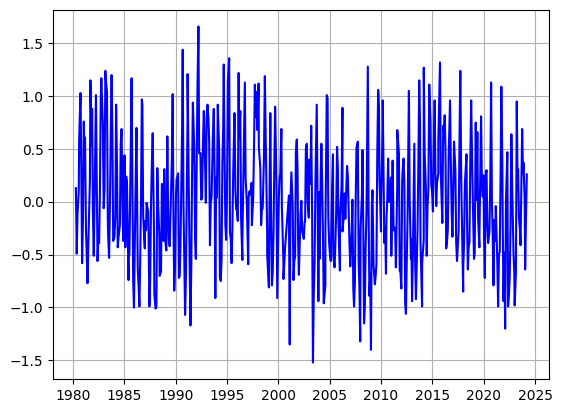

In [10]:
plt.plot(tides["MinWL"] - tides["MinWL"].mean(), color="blue", label="MinWL")
# plt.plot(tides["MaxWL"] - tides["MaxWL"].mean(), color="red", label="MaxWL")

# Unused Data Sources

## Snow Report

Source:  
https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customGroupByMonthReport/monthly/ABY:CA:SNOW%7Cid=%22%22%7Cname/POR_BEGIN,POR_END:1,2,3,4,5,6/WTEQ::collectionDate,SNWD::value,WTEQ::value

In [8]:
if 0:
    snow = pd.read_csv("./data/snow_report.csv")
    pd.to_numeric(snow["Jan.1"], errors="coerce").plot()

## Hourly Water Temperatures

Source:  
https://tidesandcurrents.noaa.gov/physocean.html?bdate=20231001&edate=20240407&units=standard&timezone=GMT&id=9419750&interval=h&action=data

In [9]:
if 0:
    water_temps = pd.read_csv("./data/CO-OPS_9419750_physocean.csv").drop(
        columns="Conductivity (mS/cm)"
    )
    # water_temps.head()
    water_temps["Water Temp (°F)"] = pd.to_numeric(
        water_temps["Water Temp (°F)"], errors="coerce"
    )
    hours = pd.to_datetime(water_temps["Time (GMT)"], format="%H:%M")
    dates = pd.to_datetime(water_temps["Date"])
    dates_hours = dates
    for k in range(len(dates)):
        dates_hours[k] += pd.Timedelta(hours=hours[k].hour)
    water_temps["DateTime"] = pd.to_datetime(dates_hours)
    water_temps = water_temps.set_index("DateTime").drop(columns=["Date", "Time (GMT)"])
    water_temps.head()
    water_temps["Water Temp (°F)"].plot()